In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchinfo import summary

import math
import os
import re
import urllib.request
import zipfile
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
BATCH_SIZE = 256
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#model 설계
#========================================================================================================================================================#
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BasicBlock_withoutResidualConnection(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = F.relu(out)
        return out


class Bottleneck_withoutResidualConnection(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def VGG(model_name = "VGG_16", pretrained=True):
    model_list = ["VGG_11", "VGG_13", "VGG_16", "VGG_19"]

    if model_name == "VGG_11":
        if pretrained:
            model = torchvision.models.vgg11(weights="VGG11_Weights.IMAGENET1K_V1")
        else:
            model = torchvision.models.vgg11(weights=None)
    elif model_name == "VGG_13":
        if pretrained:
            model = torchvision.models.vgg13(weights="VGG13_Weights.IMAGENET1K_V1")
        else:
            model = torchvision.models.vgg13(weights=None)
    elif model_name == "VGG_16":
        if pretrained:
            model = torchvision.models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
        else:
            model = torchvision.models.vgg16(weights=None)
    elif model_name == "VGG_19":
        if pretrained:
            model = torchvision.models.vgg19(weights="VGG19_Weights.IMAGENET1K_V1")
        else:
            model = torchvision.models.vgg19(weights=None)
    else:
        assert model_name not in model_list, "model name is not appropriate"

    for param in model.parameters():
        param.requires_grad = True

    return model

def ResNetCIFAL10(model_name = "RESNET_18"):
    model_list = ["RESNET_18", "RESNET_34", "RESNET_50", "RESNET_101", "RESNET_152"]
    
    if model_name == "RESNET_18":
        model = ResNet(BasicBlock, [2, 2, 2, 2])
    elif model_name == "RESNET_34":
        model = ResNet(BasicBlock, [3, 4, 6, 3])
    elif model_name == "RESNET_50":
        model = ResNet(Bottleneck, [3, 4, 6, 3])
    elif model_name == "RESNET_101":
        model = ResNet(Bottleneck, [3, 4, 23, 3])
    elif model_name == "RESNET_152":
        model = ResNet(Bottleneck, [3, 8, 36, 3])
    else:
        assert model_name not in model_list, "model name is not appropriate"

    return model

def ResNetCIFAL10_withoutSkipConnection(model_name = "RESNET_18"):
    model_list = ["RESNET_18", "RESNET_34", "RESNET_50", "RESNET_101", "RESNET_152"]
    
    if model_name == "RESNET_18":
        model = ResNet(BasicBlock_withoutResidualConnection, [2, 2, 2, 2])
    elif model_name == "RESNET_34":
        model = ResNet(BasicBlock_withoutResidualConnection, [3, 4, 6, 3])
    elif model_name == "RESNET_50":
        model = ResNet(Bottleneck_withoutResidualConnection, [3, 4, 6, 3])
    elif model_name == "RESNET_101":
        model = ResNet(Bottleneck_withoutResidualConnection, [3, 4, 23, 3])
    elif model_name == "RESNET_152":
        model = ResNet(Bottleneck_withoutResidualConnection, [3, 8, 36, 3])
    else:
        assert model_name not in model_list, "model name is not appropriate"

    return model

In [4]:
# dataset 및 transform 정의
#========================================================================================================================================================#

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# 시각화 및 보조 함수/ 기타
#========================================================================================================================================================#
def correct_function(predicted, labels):
    correct = (predicted == labels).float().mean()
    return correct

def Loss_Visualization(train1_losses, train2_losses, model_name1="Model1", model_name2="Model2", mode="Training"):
    plt.plot(range(len(train1_losses)), train1_losses, 'b-',label=f'{model_name1} {mode} Loss')
    plt.plot(range(len(train2_losses)), train2_losses,'r--', label=f'{model_name2} {mode} Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{mode} Loss {model_name1} v.s. {model_name2}")
    plt.show()

def Acc_Visualization(train_acc, val_acc, model_name1="Model1", model_name2="Model2", mode="Training"):
    plt.plot(range(len(train_acc)), train_acc, 'b-',label=f'{model_name1} {mode} Acc')
    plt.plot(range(len(val_acc)), val_acc,'r--', label=f'{model_name2} {mode} Acc')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.title(f"{mode} Acc {model_name1} v.s. {model_name2}")
    plt.show()


def plot_grad_ridgeline(hist_name, grad_dict, distance=5, bins=50, scale=0.2, elev=20, azim=135, cmap_name="viridis"):
    grads_list_all = grad_dict[hist_name]
    grads_list = grads_list_all[::distance]  # list of 1D tensors (epoch별)
    n_slices = len(grads_list)

    all_vals = torch.cat([g.detach().flatten().cpu() for g in grads_list])
    vmin, vmax = float(all_vals.min()), float(all_vals.max())

    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # figure & axis
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(cmap_name)

    # 각 epoch마다 1D 히스토그램을 x-z 평면에 그리고,
    # y축(epoch 방향)으로 한 칸씩 밀어서 쌓는다.
    for i, g in enumerate(grads_list):
        g_np = g.detach().cpu().numpy()
        counts, _ = np.histogram(g_np, bins=bin_edges, density=False)

        epoch_idx = i * distance  # 실제 epoch 번호
        # x: gradient, z: count, y: epoch
        xs = bin_centers
        ys = np.full_like(xs, epoch_idx, dtype=float)
        zs = counts
        
        verts = []
        verts.append((xs[0], ys[0], 0.0))
        for x, y, z in zip(xs, ys, zs):
            verts.append((x, y, z))
        verts.append((xs[-1], ys[-1], 0.0))

        poly = Poly3DCollection([verts], alpha=0.7)
        color = cmap(i / max(1, n_slices - 1))
        poly.set_facecolor(color)
        poly.set_edgecolor("k")
        poly.set_linewidth(0.3)
        ax.add_collection3d(poly)

    ax.set_xlabel("Gradients")
    ax.set_ylabel("Epochs")
    ax.set_zlabel("Counts")
    ax.set_title(f"Gradient Distributions: {hist_name}")
    ax.view_init(elev=elev, azim=azim)

    # 축 범위 조금 정리
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(-1, n_slices * distance + 1)

    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
def log_grad_for_layer(layer, hist_name, grad_dict):
    grads = []
    for p in layer.parameters():
        if p.grad is None:
            continue
        g = p.grad.detach().cpu().reshape(-1)
        grads.append(g)
    if not grads:
        return
    
    grads = torch.cat(grads)

    if hist_name not in grad_dict:
        grad_dict[hist_name] = []
    grad_dict[hist_name].append(grads)

In [6]:
# 학습 함수
#=======================================================================================================================================================================
def train_model(model1, model2, train_dataset, train_ratio=0.8,
                criterion = 'CE', optimize='SGD', batch_size=256, 
                epochs=50, lr = 0.001, verbose = 1, isTrained = False, 
                random_state=None, view_accurate_value = False, 
                layer_num=1, distance=5, model1_name="Model1", 
                model2_name="Model2", hist_name="layer1"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if isTrained:
        model1.to(device)
        model2.to(device)
    else:
        model1 = model1(
            dropout=DROPOUT
        )
        model2 = model2(
            dropout=DROPOUT
        )
    
        model1.to(device)
        model2.to(device)

    # 손실 함수
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = nn.CrossEntropyLoss() 

    # 옵티마이저
    if optimize=='AdamW':
        optimizer1=optim.AdamW(model1.parameters(), lr=lr)
        optimizer2=optim.AdamW(model2.parameters(), lr=lr)
    elif optimize=='Adam':
        optimizer1=optim.Adam(model1.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)
        optimizer2=optim.Adam(model2.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)
    elif optimize=="SGD":
        optimizer1=optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
        optimizer2=optim.SGD(model2.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer1=optim.Adam(model1.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)
        optimizer2=optim.Adam(model2.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)

    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size
    if random_state is None:
        # 랜덤하게 dataset나누기
        tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    else:
        manual_seed = random_state
        generator = torch.Generator().manual_seed(manual_seed)
    
        # 랜덤하게 dataset나누기
        tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

    train_losses1 = []
    val_losses1 = []
    train_acc_list1 = []
    val_acc_list1 = []
    train_losses2 = []
    val_losses2 = []
    train_acc_list2 = []
    val_acc_list2 = []

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model1_hist = dict()
    model2_hist = dict()
    best_val_loss1 = float('inf')
    best_val_loss2 = float('inf')
    best_param1 = dict()
    best_param2 = dict()
    
    model1.train()
    model2.train()

    

    for epoch in range(epochs):
        total_loss1, total_acc1, total_loss2, total_acc2 = 0, 0, 0, 0
        # PyTorch DataLoader 설정. epoch 마다 trainset에서 섞이게 만듦
        train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)

        for step, batch in enumerate(train_loader):
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            loss1, correct1, loss2, correct2 = train_step(model1, model2, batch, optimizer1, optimizer2, criterion1, criterion2, device)
            total_loss1 += loss1
            total_acc1 += correct1
            total_loss2 += loss2
            total_acc2 += correct2                

        avg_loss1 = total_loss1 / len(train_loader)
        avg_acc1 = total_acc1 / len(train_loader)
        avg_loss2 = total_loss2 / len(train_loader)
        avg_acc2 = total_acc2 / len(train_loader)
        train_losses1.append(avg_loss1)
        train_acc_list1.append(avg_acc1.to('cpu'))
        train_losses2.append(avg_loss2)
        train_acc_list2.append(avg_acc2.to('cpu'))

        it1 = iter(model1.children())
        it2 = iter(model2.children())

        for _ in range(layer_num+1):
            model1_target_layer = next(it1)
            model2_target_layer = next(it2)
        log_grad_for_layer(model1_target_layer ,f"{model1_name}_layer1", model1_hist)
        log_grad_for_layer(model2_target_layer ,f"{model2_name}_layer1", model2_hist)
        
        # Validation loss 계산
        model1.eval()
        model2.eval()
        val_loss1, val_acc1, val_loss2, val_acc2 = 0, 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                loss1, correct1, loss2, correct2 = eval_step(model1, model2, batch, criterion1, criterion2, device)

                val_loss1 += loss1
                val_acc1 += correct1
                val_loss2 += loss2
                val_acc2 += correct2

        val_loss1 /= len(val_loader)
        val_losses1.append(val_loss1)
        val_acc1 /= len(val_loader)
        val_acc_list1.append(val_acc1.to('cpu'))
        val_loss2 /= len(val_loader)
        val_losses2.append(val_loss2)
        val_acc2 /= len(val_loader)
        val_acc_list2.append(val_acc2.to('cpu'))

        # Early Stopping 조건
        if val_loss1 < best_val_loss1:
            best_val_loss1 = val_loss1
            best_param1 = copy.deepcopy(model1.state_dict())
        if val_loss2 < best_val_loss2:
            best_val_loss2 = val_loss2
            best_param2 = copy.deepcopy(model2.state_dict())
       
        if (epoch+1)%verbose==0:
            if view_accurate_value:
                print(f"{model1_name}|Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss1}, Train Acc: {avg_acc1} | Val Loss: {val_loss1}, Val Acc: {val_acc1}")
                print(f"{model2_name}|Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss2}, Train Acc: {avg_acc2} | Val Loss: {val_loss2}, Val Acc: {val_acc2}")
            else:
                print(f"{model1_name}|Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss1:.4f}, Train Acc: {avg_acc1:.4f} | Val Loss: {val_loss1:.4f}, Val Acc: {val_acc1:.4f}")
                print(f"{model2_name}|Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss2:.4f}, Train Acc: {avg_acc2:.4f} | Val Loss: {val_loss2:.4f}, Val Acc: {val_acc2:.4f}")
                
        model1.train()
        model2.train()
        
    model1.eval()
    model2.eval()
    Loss_Visualization(train_losses1, train_losses2, model_name1=model_name1, model_name2=model_name2)
    Loss_Visualization(val_losses1, val_losses2, model_name1=model_name1, model_name2=model_name2, mode = 'validation')
    Acc_Visualization(train_acc_list1, train_acc_list2, model_name1=model_name1, model_name2=model_name2)
    Acc_Visualization(val_acc_list1, val_acc_list2, model_name1=model_name1, model_name2=model_name2, mode = 'validation')
    plot_grad_ridgeline(f"{model1_name}_layer1", model1_hist, distance=distance)
    plot_grad_ridgeline(f"{model2_name}_layer1", model2_hist, distance=distance)
    model1.load_state_dict(best_param1)
    model2.load_state_dict(best_param2)
    if not isTrained:
        return model1, model2

def train_step(model1, model2, batch, optimizer1, optimizer2, loss_function1, loss_function2, device):
    model1.train()
    model2.train()
    img, label = [x.to(device) for x in batch]

    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # 모델 포워드 패스
    logits1  = model1(img)
    logits2  = model2(img)

    _, predicted1 = torch.max(logits1, 1)
    _, predicted2 = torch.max(logits2, 1)

    # Loss 계산
    loss1 = loss_function1(logits1, label)
    loss2 = loss_function2(logits2, label)

    # Backpropagation
    loss1.backward()
    optimizer1.step()
    loss2.backward()
    optimizer2.step()

    return loss1.item(), correct_function(predicted1, label), loss2.item(), correct_function(predicted2, label)
    
def eval_step(model1, model2, batch, loss_function1, loss_function2, device):
    model1.eval()
    model2.eval()
    
    img, label = [x.to(device) for x in batch]
    
    # 모델 포워드 패스
    logits1  = model1(img)
    logits2  = model2(img)
    
    _, predicted1 = torch.max(logits1, 1)
    _, predicted2 = torch.max(logits2, 1)
    
    # Loss 계산
    loss1 = loss_function1(logits1, label)
    loss2 = loss_function2(logits2, label)
    
    return loss1.item(), correct_function(predicted1, label), loss2.item(), correct_function(predicted2, label)

In [21]:
# 태스트 함수
#=======================================================================================================================================================================
def test(model, dataset, batch_size, loss_rec=[]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn = nn.CrossEntropyLoss()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    loss_rec.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 

In [8]:
# ResNet_34 parameter 및 선언
resnet_34 = ResNetCIFAL10(model_name = "RESNET_34")
summary(resnet_34)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Sequential: 3-5              --
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─Conv2d: 3-8                  36,864
│    │    └─BatchNorm2d: 3-9             128
│    │    └─Sequential: 3-10             --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13                 36,864
│    │    └─BatchNorm2d: 3-14         

In [9]:
# ResNet_16 parameter 및 선언
resnet_50 = ResNetCIFAL10(model_name = "RESNET_50")
summary(resnet_50)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─Sequential: 3-7              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-8                  16,384
│    │    └─BatchNorm2d: 3-9             128
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11            128
│    │    └─Conv2d: 3-12                 16,384
│    │    └─BatchNorm2d: 3-13            512
│    │    └─Sequential: 3-14             --
│    └─Bottleneck: 2-3            

In [10]:
# ResNet_16 parameter 및 선언 (no residual connection)
resnet_34_no_res = ResNetCIFAL10_withoutSkipConnection(model_name = "RESNET_34")
summary(resnet_34_no_res)

Layer (type:depth-idx)                                  Param #
ResNet                                                  --
├─Conv2d: 1-1                                           1,728
├─BatchNorm2d: 1-2                                      128
├─Sequential: 1-3                                       --
│    └─BasicBlock_withoutResidualConnection: 2-1        --
│    │    └─Conv2d: 3-1                                 36,864
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─Conv2d: 3-3                                 36,864
│    │    └─BatchNorm2d: 3-4                            128
│    └─BasicBlock_withoutResidualConnection: 2-2        --
│    │    └─Conv2d: 3-5                                 36,864
│    │    └─BatchNorm2d: 3-6                            128
│    │    └─Conv2d: 3-7                                 36,864
│    │    └─BatchNorm2d: 3-8                            128
│    └─BasicBlock_withoutResidualConnection: 2-3        --
│    │    └─Conv2d: 3-9    

In [11]:
# ResNet_16 parameter 및 선언 (no residual connection)
resnet_50_no_res = ResNetCIFAL10_withoutSkipConnection(model_name = "RESNET_50")
summary(resnet_50_no_res)

Layer (type:depth-idx)                                  Param #
ResNet                                                  --
├─Conv2d: 1-1                                           1,728
├─BatchNorm2d: 1-2                                      128
├─Sequential: 1-3                                       --
│    └─Bottleneck_withoutResidualConnection: 2-1        --
│    │    └─Conv2d: 3-1                                 4,096
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─Conv2d: 3-3                                 36,864
│    │    └─BatchNorm2d: 3-4                            128
│    │    └─Conv2d: 3-5                                 16,384
│    │    └─BatchNorm2d: 3-6                            512
│    │    └─Sequential: 3-7                             16,896
│    └─Bottleneck_withoutResidualConnection: 2-2        --
│    │    └─Conv2d: 3-8                                 16,384
│    │    └─BatchNorm2d: 3-9                            128
│    │    └─Conv2d: 3-10

In [12]:
#Hyperparameters
#================================================================================
BATCH_SIZE = 512
LR = 0.0001
EPOCH = 100
RANDOM_STATE = random.randint(0, 1000000000)

Using device: cuda
Resnet34|Epoch 10/100 | Train Loss: 1.4365, Train Acc: 0.4805 | Val Loss: 1.4984, Val Acc: 0.4352
Resnet34_no_skip|Epoch 10/100 | Train Loss: 1.8510, Train Acc: 0.2760 | Val Loss: 1.8401, Val Acc: 0.2741
Resnet34|Epoch 20/100 | Train Loss: 0.9793, Train Acc: 0.6674 | Val Loss: 1.3204, Val Acc: 0.5203
Resnet34_no_skip|Epoch 20/100 | Train Loss: 1.5843, Train Acc: 0.3887 | Val Loss: 1.6021, Val Acc: 0.3836
Resnet34|Epoch 30/100 | Train Loss: 0.4068, Train Acc: 0.9010 | Val Loss: 1.4535, Val Acc: 0.5189
Resnet34_no_skip|Epoch 30/100 | Train Loss: 1.3123, Train Acc: 0.5051 | Val Loss: 1.4586, Val Acc: 0.4659
Resnet34|Epoch 40/100 | Train Loss: 0.0702, Train Acc: 0.9975 | Val Loss: 1.8140, Val Acc: 0.5058
Resnet34_no_skip|Epoch 40/100 | Train Loss: 0.9282, Train Acc: 0.6648 | Val Loss: 1.3919, Val Acc: 0.5173
Resnet34|Epoch 50/100 | Train Loss: 0.0246, Train Acc: 0.9998 | Val Loss: 2.0236, Val Acc: 0.5066
Resnet34_no_skip|Epoch 50/100 | Train Loss: 0.5987, Train Acc: 0.79

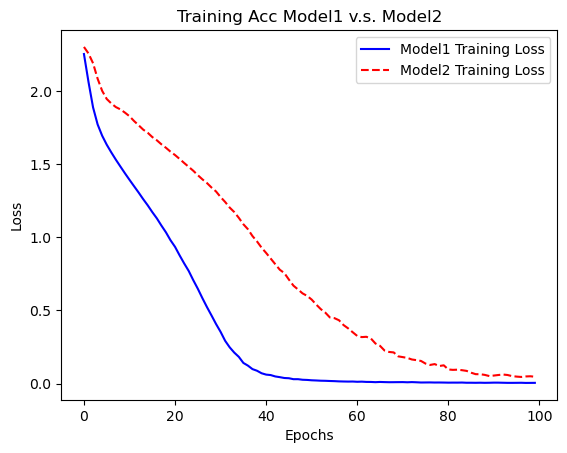

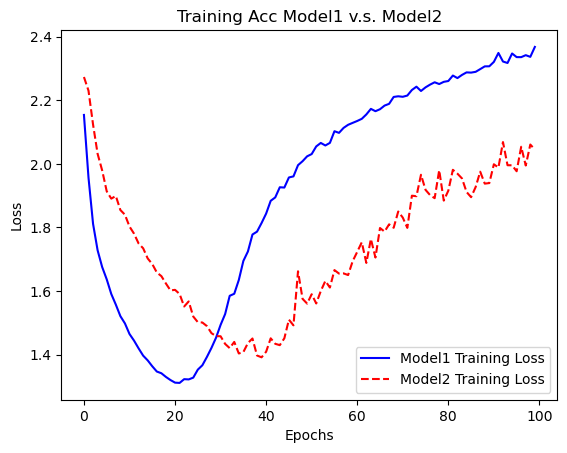

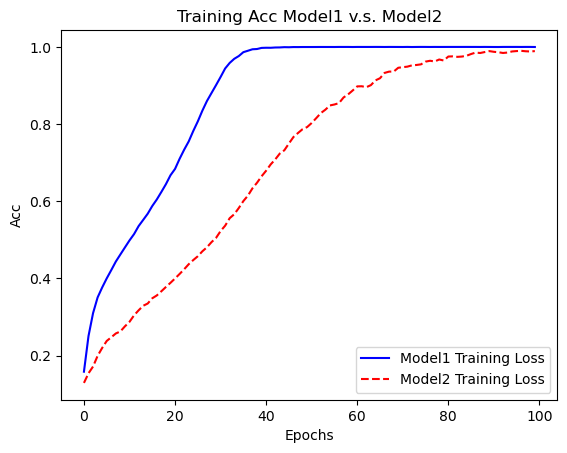

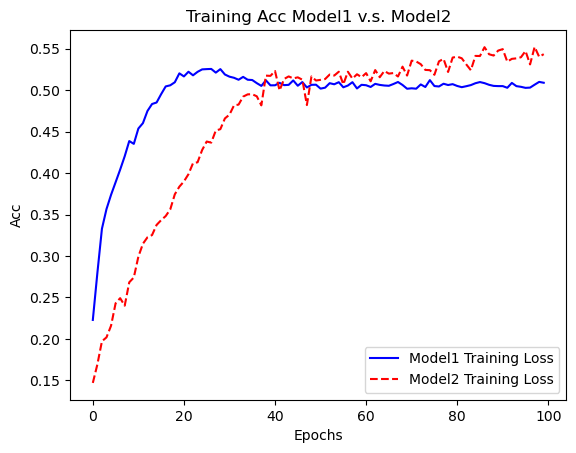

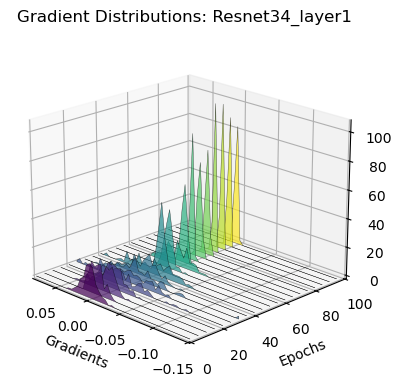

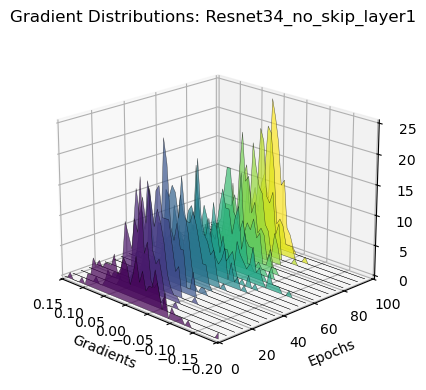

In [13]:
#실수로 그래프 타이틀이 안들어감. 순서는 아래와 같음
#Training loss
#Validation loss
#Training acc
#Validation acc
train_model(resnet_34, resnet_34_no_res, trainset, train_ratio=0.9,
        criterion = 'CE', optimize='SGD', batch_size=BATCH_SIZE, 
        epochs=EPOCH, lr = LR, verbose = 10, isTrained = True, distance=5,
        random_state=RANDOM_STATE, model1_name="Resnet34", model2_name="Resnet34_no_skip",
        hist_name="layer1")

Using device: cuda
Resnet50|Epoch 10/100 | Train Loss: 1.7433, Train Acc: 0.3458 | Val Loss: 1.7137, Val Acc: 0.3521
Resnet50_no_skip|Epoch 10/100 | Train Loss: 2.2543, Train Acc: 0.1464 | Val Loss: 2.2499, Val Acc: 0.1489
Resnet50|Epoch 20/100 | Train Loss: 1.5203, Train Acc: 0.4326 | Val Loss: 1.5289, Val Acc: 0.4340
Resnet50_no_skip|Epoch 20/100 | Train Loss: 2.0693, Train Acc: 0.2118 | Val Loss: 2.0504, Val Acc: 0.2166
Resnet50|Epoch 30/100 | Train Loss: 1.3277, Train Acc: 0.5134 | Val Loss: 1.3993, Val Acc: 0.4834
Resnet50_no_skip|Epoch 30/100 | Train Loss: 1.7630, Train Acc: 0.3364 | Val Loss: 1.7513, Val Acc: 0.3427
Resnet50|Epoch 40/100 | Train Loss: 1.1048, Train Acc: 0.6031 | Val Loss: 1.3287, Val Acc: 0.5218
Resnet50_no_skip|Epoch 40/100 | Train Loss: 1.5528, Train Acc: 0.4148 | Val Loss: 1.5983, Val Acc: 0.3954
Resnet50|Epoch 50/100 | Train Loss: 0.8093, Train Acc: 0.7215 | Val Loss: 1.3533, Val Acc: 0.5373
Resnet50_no_skip|Epoch 50/100 | Train Loss: 1.3734, Train Acc: 0.48

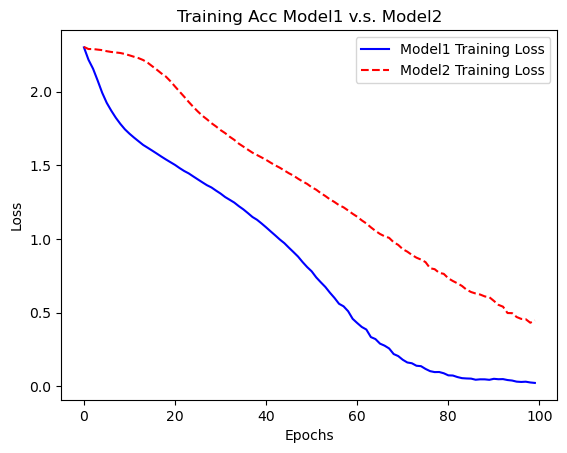

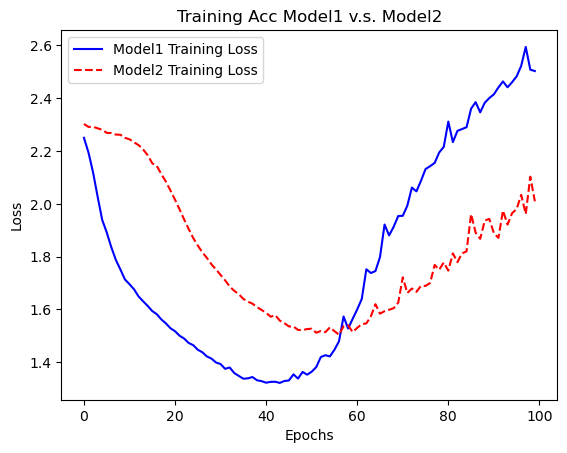

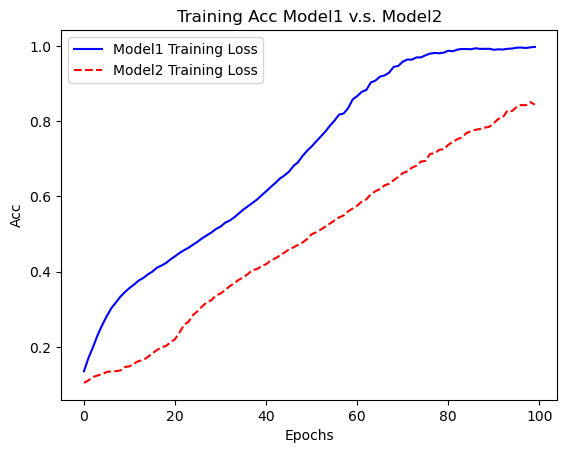

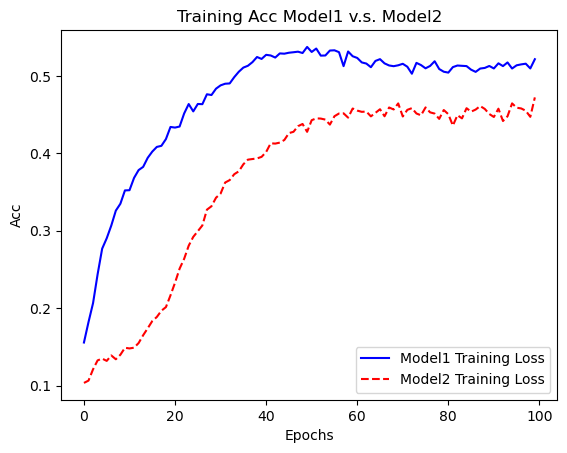

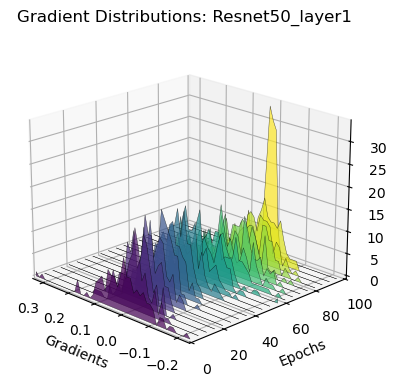

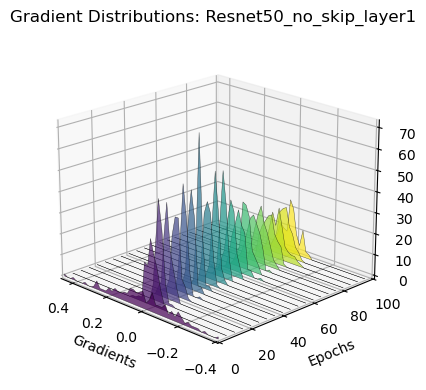

In [14]:
#실수로 그래프 타이틀이 안들어감. 순서는 아래와 같음
#Training loss
#Validation loss
#Training acc
#Validation acc
train_model(resnet_50, resnet_50_no_res, trainset, train_ratio=0.9,
        criterion = 'CE', optimize='SGD', batch_size=BATCH_SIZE, 
        epochs=EPOCH, lr = LR, verbose = 10, isTrained = True,distance=5,
        random_state=RANDOM_STATE, model1_name="Resnet50", model2_name="Resnet50_no_skip", 
        hist_name="layer1")

In [22]:
test(resnet_34, testset, batch_size=BATCH_SIZE)

Test Error: 
 Accuracy: 52.5%, Avg loss: 1.303955 



In [23]:
test(resnet_34_no_res, testset, batch_size=BATCH_SIZE)

Test Error: 
 Accuracy: 50.1%, Avg loss: 1.439232 



In [24]:
test(resnet_50, testset, batch_size=BATCH_SIZE)

Test Error: 
 Accuracy: 52.1%, Avg loss: 1.329002 



In [25]:
test(resnet_50_no_res, testset, batch_size=BATCH_SIZE)

Test Error: 
 Accuracy: 45.2%, Avg loss: 1.510068 



# 결과

ResNet34의 경우 residual connection이 없을때와 있을 때를 비교해 보았을 때 있을 때는 모델이 빠르게 수렴하여 trainging loss가 40 epoch에서 거의 0으로 accuracy가 1이 되었습니다. 반면에 skip connection이 없는경우 수렴하지 100epoch 까지 수렴하지 못하고 계속 학습하는 경향을 보였습니다. 이 결과에서 특이한 점은 100 epoch 에서의 validation 정확도 입니다. 결과는 아래와 같습니다.

|Model|Validation Accuracy|Test Accuracy|
|-----|--------|--------|
|ResNet34|0.5089|0.525|
|ResNet34_no_skip|0.5435|0.501|

위와 같이 validation의 경우 skip connection이 있는 경우가 더 높게 나타났습니다. 그래프를 확인해 본 결과, 이는 ResNet34 모델이 ResNet34_no_skip모델에 비해 빠르게 수렴하여 overfitting이 나타난 것으로 보여집니다. 이미 ResNet34모델의 경우 20epoch근처에서 validaiton loss가 증가하였으며 이는 모델의 상태가 overfitting이 되었다는 것을 뒷바침 해줍니다. 이와 반대로 ResNet34_no_skip모델은 거의 100 epoch 근처에서 training loss가 0에 가까웠습니다. 즉, training loss에 대하여 ResNet34_no_skip모델은 추가적인 훈련을 하더라도 validation set에 대하여 accuracy가 증가 할 가능성이 거의 없습니다.

두 모델의 첫번째 layer의 경우 training dataset에 대하여 ResNet34 모델은 overfitting이 되었기 때문에 거의 모든 label을 다 맞추는 40epoch 근처에서 gradient 가 거의 0에 가깝게 나오는 것을 확인할 수 있습니다. 이에 대하여 overfitting이 나타나는 40epoch 전의 histogram을 살펴보면 gradient가 거의 고르게 분포되어 있다가 overfitting이 발생하는 20epoch 근처에서 0으로 점차 수렴하는 것을 확인할 수 있습니다. 이는 overfitting이 나타날 경우에만 gradient가 0으로 수렴한다는 사실을 알수 있게 해줍니다. 이와 반대로, ResNet34_no_skip모델의 경우 100epoch 까지 불안정한 모습을 보이며 점점 gradient 값이 0으로 수렴이 되는 매우 불안정한 그레프가 나타나었습니다. 이미 overfitting의 경향성은 40epoch에서 나타났기 때문에 이후 추가적인 학습을 하더라도 gradient vanishing 현상이 진행되는것을 관측 할수 있는 것으로 확인됩니다. 

최종적으로 정확도가 ResNet34모델이 낮은 이유에 대한 가능성으로는 3가지를 재시할 수 있습니다.
1. ResNet34_no_skip모델이 우연에 의해서 더 높은 성능을 갖는것으로 나타났다.
2. ResNet34_no_skip모델이 더 단순하고 데이터도 ResNet34모델에 비해 단순하여 ResNet34_no_skip모델이 unseem data를 예측하기에 더 적절하였다.
3. Residual connection의 효과 발휘하기에는 충분히 layer의 depth가 깊지 않았다.

이번 실험에서 사용한 CIFAR10(6만 데이터)은 IMAGENET(1,400만 데이터)에 비하여 데이터가 0.4286% 정도로 아주 적은 dataset이며 모든 경향성을 확인하기에 부족할 수도 있습니다. 또한 IMAGENET은 224x224 이미지로 데이터의 복잡성에서도 큰 차이가 있습니다.

ResNet50과 Resnet50_no_skip 모델의 경우도 비슷한 경향성을 보여주며 validationset에 대하여 결과는 다음과 같습니다.

|Model|Validation Accuracy|Test Accuracy|
|-----|--------|--------|
|ResNet50|0.5053|0.521|
|ResNet50_no_skip|0.4559|0.452|

모델의 depth가 깊어질 경우 차이가 더욱 두드러 집니다. 이는 skip connection이 깊은 depth에서 더 큰 효과를 갖고 있다는 것을 정량적으로 증명합니다. 즉, 위에서 재시한 가정 중 3번 가정을 확인해 볼 수 있었습니다.

또한 첫번째 layer의 gradient를 확인해보면 depth가 낮을때와 달리 depth가 높을 때는 초반에 gradient vanishing이 나타나고 후반에 gradient가 안정되는 것을 볼 수 있습니다. 하지만 모델이 gradient vanishing이 사라져 안정되었을 때는 이미 overfitting이 나타나는 것을 확인해 볼 수 있습니다. 이는 skip connection 없는 모델에서 모든 layer를 효과적으로 갱신할 수 없음을 의미합니다. 즉, 입력쪽에 가까운 layer가 overfitting 시점이 지난 이후에 안정화 되면서 효율적이지 못한 학습을 하게 됩니다. 

결론적으로, skip connection이 존재 할 경우 모델이 깊어지면 깊어질 수록 더욱 큰 효과를 만들어 내며 degradation problem을 효과적으로 해결했다는 것을 알 수 있습니다.